# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.




<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)



<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')

**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]


#Using .shape to fimd the number of rows

294478

**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()
#Using nuniqie to find the number of unique user ids

290584

**d.** The proportion of users converted.

In [6]:
df['converted'].mean()
#finding the proportion of users converted with .mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]
#Creating a new df that only contains the treatment group that didn't use the new page, the counting the number of rows with .shape()

1965

In [8]:
df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]
#Creating a new df that only contains the control group that did use the new page, the counting the number of rows with .shape()

1928

**f.** Do any of the rows have missing values?

In [9]:
df.info() #No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)
df = df.drop(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index)
df2 = df
df2.shape[0]
# Using df drop to remove the rows defined in question e

290585

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()
#using nunique to find the number of unique users

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated('user_id')] 
#using .duplicated to find the user with the duplicate value.

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [14]:
df2.query('user_id == "773192"')


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
delete = df2.query('index == "2893"')
df2 = df2.drop(delete.index)
df2.query('user_id == "773192"')
# removing only one of the duplicate values by using its unique index value

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0



**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [16]:
p_pop = df2['converted'].mean()
p_pop
#finding the probability of conversion using .mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = df2[df2['group'] == 'control']['converted'].mean()
p_control
#finding the probability of conversion given that they were in the control group

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment = df2[df2['group'] == 'treatment']['converted'].mean()
p_treatment
#finding the probability of conversion given that they were in the treatment group

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
p_new_page = df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]
p_new_page
#Using .shape[0] to find the number of new page rows and dividing it by the total number of rows to find the probability of a individual receiving the new page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

### Answer:
The probability that someone receieves the new page is 50%, so there is an equal split of old and new pages.

The probablilty that someone who uses the old website buys the companys product is 12.04%, and for someone who uses the new website it is 11.88%. This gives a difference of 0.16% in favour of the old website, which seems to show that the new website does not lead to more conversions.



<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

### Answer:

The null hypothesis is that there is no difference in the proportion of coonversions between the old and new page.
The alternative hypothesis is that the proportion of conversions for the new page is greater than that of the old page.

H0: p_new - p_old <= 0

H1: p_new -  p_old > 0

Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_pop

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_pop


0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [23]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new
#Using .shape[0] to find the number of rows in the treatment group

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old
#Using .shape[0] to find the number of rows in the control group

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p = [1-p_pop, p_pop])
new_page_converted
#Using np.random.choice to return an array of n_new 0 or 1's at probability 1-p_pop and p_pop, respectively


array([1, 1, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p = [1-p_pop, p_pop])
old_page_converted
#Using np.random.choice to return an array of n_old 0 or 1's at probability 1-p_pop and p_pop, respectively

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
diff_converted = new_page_converted.mean() - old_page_converted.mean()
diff_converted

-0.00031165491509257959


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 



In [28]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    p_new_page_converted = np.random.choice([0,1], n_new, p = [1-p_pop, p_pop]).mean()
    p_old_page_converted = np.random.choice([0,1], n_old, p = [1-p_pop, p_pop]).mean()
    p_diffs.append(p_new_page_converted - p_old_page_converted)
p_diffs = np.asarray(p_diffs)

#creating a sampling distribution, with 10000 iterations, which creating the difference between new page converted and old page converted, then adding these values to a empty array so that we end up with 10000 diff values.

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**. 

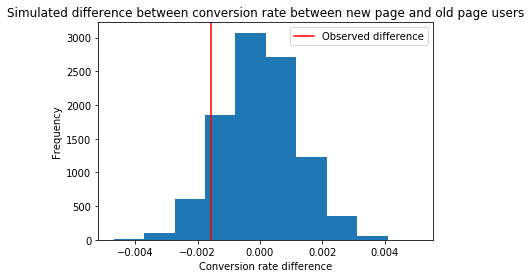

In [29]:
#Plotting histogram for P_diffs, and the vertical observed difference line via plt.axv line
plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'red', label = 'Observed difference')
plt.xlabel('Conversion rate difference')
plt.ylabel('Frequency')
plt.title('Simulated difference between conversion rate between new page and old page users')
plt.legend();

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.90590000000000004

### Answer:

In null-hypothesis significance testing, the p-value is the probability of obtaining test results at least as extreme as the result actually observed, assuming the null hypothesis is correct.

The p-value we observed is 0.91.
With a type 1 error (alpha) rating of 0.05, 0.91 is considerably larger than 0.05, therefore there is not enough evidence to reject the null hypothesis.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query(('landing_page == "old_page" & converted == "1"')).shape[0]

# number of conversions with the new_page
convert_new = df2.query(('landing_page == "new_page" & converted == "1"')).shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

convert_new, convert_old, n_new, n_old


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17264, 17489, 145310, 145274)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value. 

In [32]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>




### Answer:

The z-score we get here is -1.311, which is the number of standard deviations from the mean a data point is.

The p-value we get is 0.905, which is very close to our p-value of 0.910 that we calculated in the previously. The two p-values agree so we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

### Answer: 

since our data is either conversion or no conversion, we will be using logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. 

In [33]:
df2['intercept'] = 1
df2['ab_page'] =pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [34]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-08 13:14 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


### Answer:
The Hypothesis we have performed this test is two-sided, compared to the part two hypothesis which was one-sided.
The P-value for this test is 0.190, which is above our alpha level of 0.05, so we failed to reject the null hypothesis once again.

### Observation:
It could be useful to observe other variables to the regression model.
By using multiple linear regression, we can estimate the relationship between two or more independent variables and a solo dependant variable.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 


Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [36]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Join with the df2 dataframe with .merge()
df3 = pd.merge(df2, df_countries, how = 'inner', on = 'user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables with pd.get_dummies
df3[['UK','US','CA']] = pd.get_dummies(df3['country'])
df3.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [39]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page',"UK", "CA"]])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-08 13:14 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [40]:
# Fit your model, and summarize the results
df3['UK_newpage'] = df3['ab_page'] * df3['UK']
df3['CA_newpage'] = df3['ab_page'] * df3['CA']

df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA,UK_newpage,CA_newpage
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [41]:
lm = sm.Logit(df3['converted'], df3[['intercept','ab_page',"UK", "CA", "UK_newpage", 'CA_newpage']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-08 13:14 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
UK_newpage   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
CA_newpage   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

### Conclusions:

After creating some interaction variables, there is still no variable what a significant p-value (all above 0.05). Therefore, we fail to reject the null hypothesis. There is insignificant evidence to suggest that there is a relation between country and page that will predict if a user purchases the company's product.

Therefore, based on the data supplied, we do not have enough evidence to suggest that the new page will result in more purchases than the old page.

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0